This example concerns a laser phase noise channel (+ AWGN), as studied in optical communication systems (https://ieeexplore.ieee.org/document/4814758). A recurrent neural network is used to estimate the phase noise in parallel to the end-to-end auto encoder. The learned constellation becomes eye shaped instead of round in order to have better properties regarding the phase noise. The recurrent neural network can be seen as a spatial transformer network [https://arxiv.org/abs/1506.02025, https://arxiv.org/abs/1605.00716]. 

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft

from tensorflow.keras.layers import RNN, GRUCell

In [2]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 64
if chParam.M == 16:
    chParam.SNR_db = 12.5
    chParam.ph_noise_factor = 1.4e-4
else:
    chParam.SNR_db = 20
    chParam.ph_noise_factor = 1e-4    

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.constellationDim   = 2
aeParam.constellationOrder = chParam.M
aeParam.time_steps         = 256
aeParam.nLayers            = 2
aeParam.nHidden            = 32
aeParam.rnnLayers          = [24, 24, 1]
aeParam.rnnBidirectional   = False
aeParam.activation         = tf.nn.relu
aeParam.dtype              = tf.float32
aeParam.cpx_dtype          = tf.complex64

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.nBatches      = 4
trainingParam.batchSize     = 4*chParam.M
trainingParam.learningRate  = 0.001
trainingParam.displayStep   = 25
trainingParam.path          = 'results_AWGN_phase_end2end'
trainingParam.filename      = 'M{}'.format(chParam.M)
trainingParam.lambdaPh      = [20, 120]
trainingParam.iterations    = 400

# TF constants
one = tf.constant(1, aeParam.dtype)

zeroOneCpx = tf.constant(0+1j, aeParam.cpx_dtype)
twoZeroCpx = tf.constant(2, aeParam.cpx_dtype)

In [3]:
# Tx Graph     
X = tf.placeholder(aeParam.dtype, shape=(None, aeParam.time_steps, chParam.M))
enc, enc_seed = ae.encoder(X, aeParam, toComplex=True)

W1207 13:05:12.163414 139973073241920 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
# Phase noise    
simga2_ph = tf.constant(2 * np.pi * chParam.ph_noise_factor, aeParam.dtype)
noise_ph = tf.random_normal(shape=[tf.shape(enc)[0], aeParam.time_steps], dtype=aeParam.dtype)
noise_ph = tf.math.sqrt(simga2_ph) * noise_ph
noise_ph = tf.cast(tf.math.cumsum(noise_ph, axis=1), aeParam.cpx_dtype)

# AWGN Channel
SNR_db = tf.constant(chParam.SNR_db, dtype=aeParam.dtype)
sigma2 = one / cfh.dB2lin(SNR_db, 'dB')
noise_cpx = tf.complex(tf.random_normal(shape=tf.shape(enc), dtype=aeParam.dtype),
                       tf.random_normal(shape=tf.shape(enc), dtype=aeParam.dtype))
noise = tf.cast(tf.sqrt(sigma2), aeParam.cpx_dtype)\
        *tf.rsqrt(twoZeroCpx)*noise_cpx

# All the channel
channel_out = tf.exp(zeroOneCpx * noise_ph) * enc + noise

In [5]:
# RNN for phase noise
rnnLayer = cfh.complex2real(channel_out)

if aeParam.rnnBidirectional:
    rnnLayerFw = RNN(GRUCell(aeParam.rnnLayers[0]), go_backwards=False, return_sequences=True)(rnnLayer)
    rnnLayerBw = RNN(GRUCell(aeParam.rnnLayers[0]), go_backwards=True, return_sequences=True)(rnnLayer)
    rnnLayer = tf.concat((rnnLayerFw,rnnLayerBw), axis=-1)

    cells = [GRUCell(n) for n in aeParam.rnnLayers[1:]]    
else:
    cells = [GRUCell(n) for n in aeParam.rnnLayers]
    
rnnOutput = RNN(cells, return_sequences=True)(rnnLayer)

In [6]:
# compensate for phase noise
est_noise_ph = tf.squeeze(tf.cast(rnnOutput, aeParam.cpx_dtype),-1)
loss_ph = tf.reduce_mean(tf.square(tf.abs(est_noise_ph - noise_ph)))
channel_ph = channel_out * tf.exp(-zeroOneCpx * est_noise_ph)

# feed phase noise compensated signal into decoder NN
dec = ae.decoder(channel_ph, aeParam, fromComplex=True)
per_ex_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=dec)
softmax = tf.nn.softmax(dec)

In [7]:
# Neural Network MI, with -> softmax = P(x|y)
Px = tf.constant( 1/chParam.M, aeParam.dtype )
softmax_MI = cfh.softmaxMI(softmax, X, Px)

# Loss
correct_prediction = tf.equal(tf.argmax(X,-1), tf.argmax(dec,-1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))

# use this hyperparameter to make loss on phase noise less important
# the longer training goes on, this helps the RNN in the beginning of
# training to figure things out
lambda_ph = tf.placeholder(aeParam.dtype, ())
loss = tf.reduce_mean(per_ex_loss) + lambda_ph * loss_ph

optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss)

W1207 13:05:14.454145 139973073241920 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
metricsDict = {'xentropy':loss, 'accuracy_metric':accuracy, 'softmax_MI':softmax_MI}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

W1207 13:05:17.756558 139973073241920 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

In [10]:
bestLoss = 10000
for epoche in range(1, trainingParam.iterations+1):
    sess.run(resetOps)
    
    # help RNN to get phase noise right in
    # the beginning of training
    if epoche < trainingParam.lambdaPh[0] + 1:
        lambdaPh = 1
    elif epoche >= trainingParam.lambdaPh[0] + 1:
        lambdaPh = 1/(epoche-trainingParam.lambdaPh[0])
    elif epoche > trainingParam.lambdaPh[1]:
        lambdaPh = 0
        
    for batch in range(0, trainingParam.nBatches):
        data, _, _ = cu.hotOnes((trainingParam.batchSize,aeParam.time_steps),(1,2,0),chParam.M)
        feedDict = {X: data, lambda_ph: lambdaPh}
        sess.run([optimizer, updateOps], feed_dict=feedDict)

    [outAvgLoss, outAvgAccuracy, outSoftmaxMI] = sess.run([meanMetricOpsDict['xentropy'],
                                             meanMetricOpsDict['accuracy_metric'],
                                             meanMetricOpsDict['softmax_MI']], feed_dict=feedDict)
    
    if epoche%trainingParam.displayStep == 0:
        print('epoche: {} - avgLoss: {} - avgMI: {} - avgAcc: {}'.format(epoche,outAvgLoss,outSoftmaxMI,outAvgAccuracy))
        
    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

epoche: 25 - avgLoss: 3.3639135360717773 - avgMI: 1.1568180322647095 - avgAcc: 0.08426284790039062
epoche: 50 - avgLoss: 2.379732131958008 - avgMI: 2.5679125785827637 - avgAcc: 0.2524757385253906
epoche: 75 - avgLoss: 1.8157480955123901 - avgMI: 3.380998134613037 - avgAcc: 0.4535484313964844
epoche: 100 - avgLoss: 1.4022971391677856 - avgMI: 3.9772324562072754 - avgAcc: 0.5928916931152344
epoche: 125 - avgLoss: 1.1339808702468872 - avgMI: 4.364231109619141 - avgAcc: 0.6810874938964844
epoche: 150 - avgLoss: 0.9613277912139893 - avgMI: 4.613265037536621 - avgAcc: 0.7277641296386719
epoche: 175 - avgLoss: 0.8517400622367859 - avgMI: 4.77133321762085 - avgAcc: 0.7481307983398438
epoche: 200 - avgLoss: 0.785216212272644 - avgMI: 4.86728572845459 - avgAcc: 0.7585525512695312
epoche: 225 - avgLoss: 0.7317849397659302 - avgMI: 4.944358825683594 - avgAcc: 0.7689437866210938
epoche: 250 - avgLoss: 0.687544584274292 - avgMI: 5.0081682205200195 - avgAcc: 0.7768287658691406
epoche: 275 - avgLoss: 

In [11]:
[outNoise_ph, outEst_noise_ph] = sess.run([noise_ph,est_noise_ph], feed_dict=feedDict)

/home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


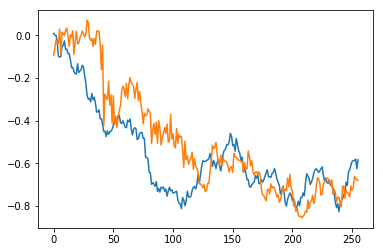

In [12]:
plt.plot(outNoise_ph[0,:])
plt.plot(outEst_noise_ph[0,:])

In [13]:
saver.restore(sess=sess,save_path=checkpoint_path)
[outEnc, outChannel_out, outChannel_ph] = sess.run([enc,channel_out,channel_ph], feed_dict=feedDict)

W1207 13:24:33.210374 139973073241920 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


(-1.5, 1.5)

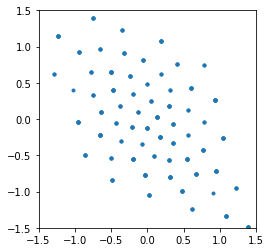

In [14]:
lim_ = 1.5
plt.plot(np.real(outEnc[0,:]), np.imag(outEnc[0,:]),'.')
plt.axis('square');
plt.xlim(-lim_,lim_)
plt.ylim(-lim_,lim_)